In [ ]:
# Load packages

import os
import zipfile
import shutil
import glob
import fiona
import pyproj
import numpy as np
import shapefile

from affine import Affine
from osgeo import gdal
from scipy.interpolate import griddata
from descartes import PolygonPatch

import netCDF4 as nc
from netCDF4 import Dataset

import rasterio
from rasterio.crs import CRS
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling

import xarray as xr
import rioxarray as rio
from rioxarray.exceptions import NoDataInBounds

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize

from mpl_toolkits.basemap import Basemap

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import geopandas as gpd
import pandas as pd

from shapely.geometry import shape
from shapely.geometry import mapping

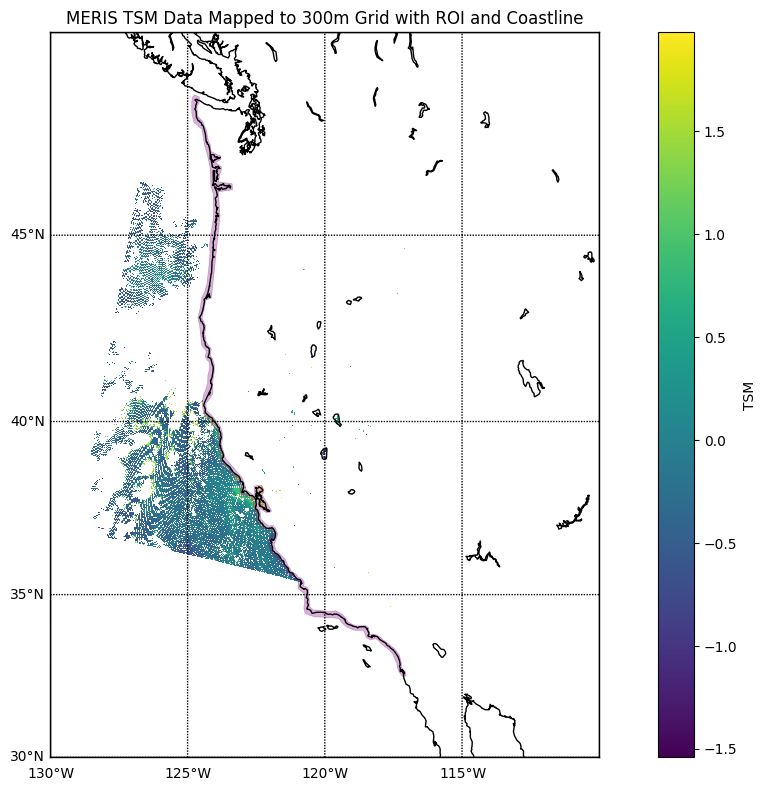

In [ ]:
# Create latitude / longitude grid and use this to geolocate and map TSM data

# Step 1: Create reference lat/lon grid (300m ≈ 0.0027 deg)
lat_min, lat_max = 30, 50
lon_min, lon_max = -130, -110
res_deg = 0.0027

ref_lats = np.arange(lat_min, lat_max, res_deg)
ref_lons = np.arange(lon_min, lon_max, res_deg)
ref_lon_grid, ref_lat_grid = np.meshgrid(ref_lons, ref_lats)

# Step 2: Load TSM and geolocation data
tsm_ds = xr.open_dataset("/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/tsm_nn.nc")
geo_ds = xr.open_dataset("/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/geo_coordinates.nc")

tsm_data = tsm_ds['TSM_NN'].values  # Update var name
lat_data = geo_ds['latitude'].values
lon_data = geo_ds['longitude'].values

# Step 3: Flatten and remove NaNs
mask = ~np.isnan(tsm_data)
tsm_vals = tsm_data[mask]
lat_vals = lat_data[mask]
lon_vals = lon_data[mask]

# Step 4: Match to reference grid using nearest neighbor (indexing)
# Calculate 2D bin indices for each lat/lon value
lat_idx = np.searchsorted(ref_lats, lat_vals) - 1
lon_idx = np.searchsorted(ref_lons, lon_vals) - 1

# Create empty array to hold gridded data
grid_tsm = np.full(ref_lon_grid.shape, np.nan)

# Fill with TSM values where they fall into the grid
for i in range(len(tsm_vals)):
    if 0 <= lat_idx[i] < grid_tsm.shape[0] and 0 <= lon_idx[i] < grid_tsm.shape[1]:
        grid_tsm[lat_idx[i], lon_idx[i]] = tsm_vals[i]

# Step 5: Plot with Basemap
fig, ax = plt.subplots(figsize=(12, 8))

m = Basemap(
    projection='merc',
    llcrnrlat=lat_min,
    urcrnrlat=lat_max,
    llcrnrlon=lon_min,
    urcrnrlon=lon_max,
    resolution='i',
    ax=ax
)

m.drawcoastlines()
m.drawmapboundary()
m.drawparallels(np.arange(lat_min, lat_max, 5), labels=[1,0,0,0])
m.drawmeridians(np.arange(lon_min, lon_max, 5), labels=[0,0,0,1])

# Transform lat/lon to map coordinates
x, y = m(ref_lon_grid, ref_lat_grid)

# Plot TSM data
cs = m.pcolormesh(x, y, grid_tsm, shading='auto', cmap='viridis')
plt.colorbar(cs, label="TSM NN (g.m-3)")

# Step 6: Overlay shapefile (ROI)
shp_path = "/Users/lopezama/Documents/Blackwood/MERIS/ROI/west_us_poly_ll/west_us_poly_ll"  # without .shp extension
sf = shapefile.Reader(shp_path)
for shape_rec in sf.shapeRecords():
    shape = shape_rec.shape
    points = np.array(shape.points)
    parts = list(shape.parts) + [len(points)]
    for i in range(len(parts) - 1):
        seg = points[parts[i]:parts[i+1]]
        px, py = m(seg[:, 0], seg[:, 1])
        poly = Polygon(
            list(zip(px, py)),
            facecolor='purple',
            edgecolor='purple',
            linewidth=0.5,
            alpha=0.3  # 80% transparent 0.2, 50% transparent 0.5
        )
        ax.add_patch(poly)

plt.title("MERIS TSM Data Mapped to 300m Lat/Lon Grid with ROI")
plt.tight_layout()
plt.show()


In [ ]:
# Save as new gridded TSM netcdf 

# Create DataArray with coordinates
ds = xr.Dataset(
    {
        "TSM": (("lat", "lon"), grid_tsm)
    },
    coords={
        "lat": ref_lats,
        "lon": ref_lons
    }
)

# Save to NetCDF
ds.to_netcdf("/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_full.nc")

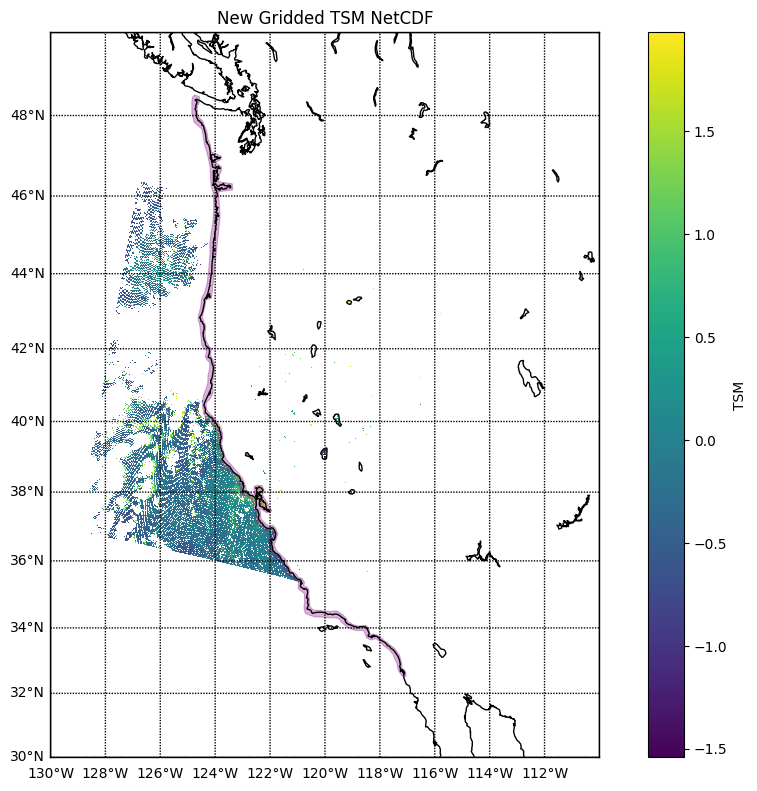

In [ ]:
# Plot new gridded TSM netcdf with ROI

# Load saved NetCDF
ds_loaded = xr.open_dataset("/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_full.nc")
tsm = ds_loaded["TSM"].values
lats = ds_loaded["lat"].values
lons = ds_loaded["lon"].values

# Create meshgrid for Basemap plotting
lon2d, lat2d = np.meshgrid(lons, lats)

# Create masked array for plotting
import numpy.ma as ma
masked_tsm = ma.masked_invalid(tsm)

# Setup Basemap
fig, ax = plt.subplots(figsize=(10, 8))

m = Basemap(
    projection='merc',
    llcrnrlat=np.min(lats),
    urcrnrlat=np.max(lats),
    llcrnrlon=np.min(lons),
    urcrnrlon=np.max(lons),
    resolution='i',
    ax=ax
)

m.drawcoastlines()
m.drawmapboundary()
m.drawparallels(np.arange(np.floor(np.min(lats)), np.ceil(np.max(lats)), 2), labels=[1,0,0,0])
m.drawmeridians(np.arange(np.floor(np.min(lons)), np.ceil(np.max(lons)), 2), labels=[0,0,0,1])

# Project coordinates
x, y = m(lon2d, lat2d)

# Plot TSM
cs = m.pcolormesh(x, y, masked_tsm, cmap='viridis', shading='auto')
plt.colorbar(cs, label="TSM NN (g.m-3)")

# Overlay ROI shapefile
shp_path = "/Users/lopezama/Documents/Blackwood/MERIS/ROI/west_us_poly_ll/west_us_poly_ll"  # without .shp extension
sf = shapefile.Reader(shp_path)
for shape_rec in sf.shapeRecords():
    shape = shape_rec.shape
    points = np.array(shape.points)
    parts = list(shape.parts) + [len(points)]
    for i in range(len(parts) - 1):
        seg = points[parts[i]:parts[i+1]]
        px, py = m(seg[:, 0], seg[:, 1])
        poly = Polygon(
            list(zip(px, py)),
            facecolor='purple',
            edgecolor='purple',
            linewidth=0.8,
            alpha=0.3  # 80% transparent 0.2, 50% transparent 0.5
        )
        ax.add_patch(poly)


plt.title("Lat/Lon Gridded TSM NetCDF")
plt.tight_layout()
plt.show()

In [ ]:
# File details gridded TSM NetCDF file with lat/lon 
tsm_nc_grid = xr.open_dataset("/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_full.nc")
tsm_nc_grid

# Check the variable names
print("Variables:", list(tsm_nc_grid.variables.keys()))

# Check latitude & longitude values
print("Latitude sample:", tsm_nc_grid["lat"].values[:10])
print("Longitude sample:", tsm_nc_grid["lon"].values[:10])

# Access CRS using rioxarray
try:
    crs = tsm_nc_grid.rio.crs
    print("CRS:", crs)
except Exception as e:
    print("Error accessing CRS:", e)

tsm_nc_grid = nc.Dataset("/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_full.nc", 'r')
tsm_nc_grid

Variables: ['TSM', 'lat', 'lon']
Latitude sample: [30.     30.0027 30.0054 30.0081 30.0108 30.0135 30.0162 30.0189 30.0216
 30.0243]
Longitude sample: [-130.     -129.9973 -129.9946 -129.9919 -129.9892 -129.9865 -129.9838
 -129.9811 -129.9784 -129.9757]
CRS: None


<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): lat(7408), lon(7408)
    variables(dimensions): float64 TSM(lat, lon), float64 lat(lat), float64 lon(lon)
    groups: 

In [ ]:
# ROI file details

# Load ROI shapefile
roi = gpd.read_file("/Users/lopezama/Documents/Blackwood/MERIS/ROI/west_us_poly_ll/west_us_poly_ll.shp")

# Get CRS info from ROI shapefile
roi_crs = roi.crs
print("ROI Shapefile CRS:", roi_crs)


ROI CRS: EPSG:4326


In [ ]:
# Assign CRS to gridded TSM netcdf

# Open the NetCDF file
dataset = xr.open_dataset("/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_full.nc", decode_coords="all")

# Assign the CRS using the EPSG code
dataset.rio.write_crs("EPSG:4326", inplace=True)

# Save the modified dataset
dataset.to_netcdf("/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_full_crs.nc")

# Double check CRS was assigned
tsm_nc_crs = xr.open_dataset("/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_full_crs.nc")

# Access CRS using rioxarray
try:
    crs = tsm_nc_crs.rio.crs
    print("Gridded TSM NetCDF CRS:", crs)
except Exception as e:
    print("Error accessing CRS:", e)



CRS: EPSG:4326


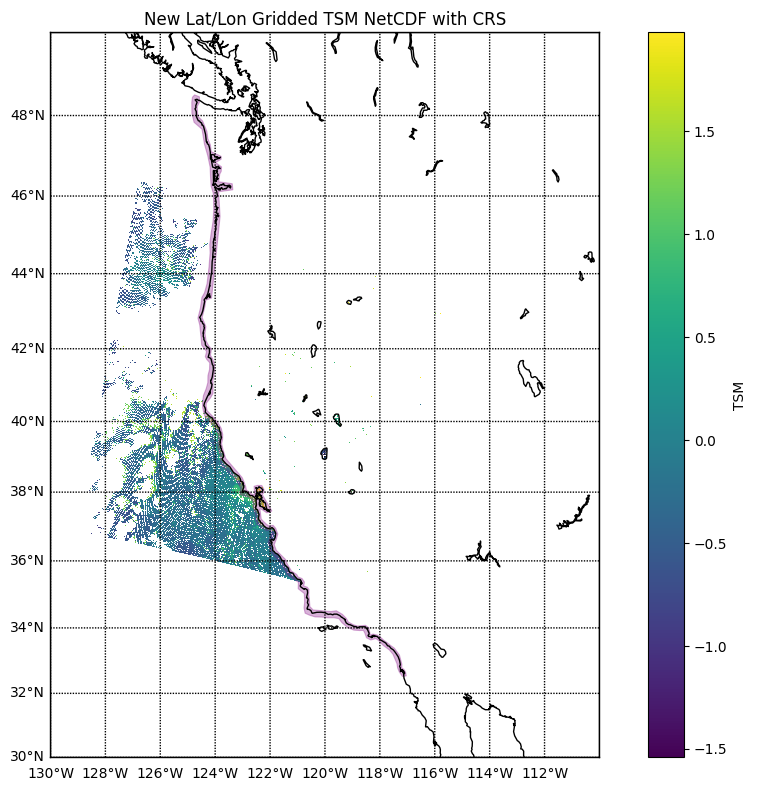

In [ ]:
# Plot gridded TSM netcdf with CRS to double check correct data plot

# Load saved NetCDF
ds_loaded = xr.open_dataset("/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_full_crs.nc")
tsm = ds_loaded["TSM"].values
lats = ds_loaded["lat"].values
lons = ds_loaded["lon"].values

# Create meshgrid for Basemap plotting
lon2d, lat2d = np.meshgrid(lons, lats)

# Create masked array for plotting
import numpy.ma as ma
masked_tsm = ma.masked_invalid(tsm)

# Setup Basemap
fig, ax = plt.subplots(figsize=(10, 8))

m = Basemap(
    projection='merc',
    llcrnrlat=np.min(lats),
    urcrnrlat=np.max(lats),
    llcrnrlon=np.min(lons),
    urcrnrlon=np.max(lons),
    resolution='i',
    ax=ax
)

m.drawcoastlines()
m.drawmapboundary()
m.drawparallels(np.arange(np.floor(np.min(lats)), np.ceil(np.max(lats)), 2), labels=[1,0,0,0])
m.drawmeridians(np.arange(np.floor(np.min(lons)), np.ceil(np.max(lons)), 2), labels=[0,0,0,1])

# Project coordinates
x, y = m(lon2d, lat2d)

# Plot TSM
cs = m.pcolormesh(x, y, masked_tsm, cmap='viridis', shading='auto')
plt.colorbar(cs, label="TSM NN (g.m-3)")

# Overlay ROI shapefile
shp_path = "/Users/lopezama/Documents/Blackwood/MERIS/ROI/west_us_poly_ll/west_us_poly_ll"  # without .shp extension
sf = shapefile.Reader(shp_path)
for shape_rec in sf.shapeRecords():
    shape = shape_rec.shape
    points = np.array(shape.points)
    parts = list(shape.parts) + [len(points)]
    for i in range(len(parts) - 1):
        seg = points[parts[i]:parts[i+1]]
        px, py = m(seg[:, 0], seg[:, 1])
        poly = Polygon(
            list(zip(px, py)),
            facecolor='purple',
            edgecolor='purple',
            linewidth=0.8,
            alpha=0.3  # 80% transparent 0.2, 50% transparent 0.5
        )
        ax.add_patch(poly)


plt.title("Lat/Lon Gridded TSM NetCDF with CRS")
plt.tight_layout()
plt.show()

In [ ]:
# Clip gridded TSM netcdf with CRS using ROI shapefile and save as new netcdf

# --- Load the ROI and make sure it's in EPSG:4326 ---
roi = gpd.read_file("/Users/lopezama/Documents/Blackwood/MERIS/ROI/west_us_poly_ll/west_us_poly_ll.shp")

# --- Load the NetCDF and prep for rioxarray ---
ds = xr.open_dataset("/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_full_crs.nc")

# Rename dims to 'x' and 'y' for rioxarray compatibility
ds_renamed = ds.rename({"lon": "x", "lat": "y"})

# Write CRS and set spatial dims
ds_rio = ds_renamed.rio.write_crs("EPSG:4326")
ds_rio = ds_rio.rio.set_spatial_dims(x_dim="x", y_dim="y")

# --- Clip using ROI geometry ---
roi_geom = [mapping(roi.geometry.union_all())]
clipped = ds_rio.rio.clip(roi_geom, crs="EPSG:4326", drop=True)

# --- Save clipped NetCDF ---
clipped.to_netcdf("/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_clip_crs.nc")

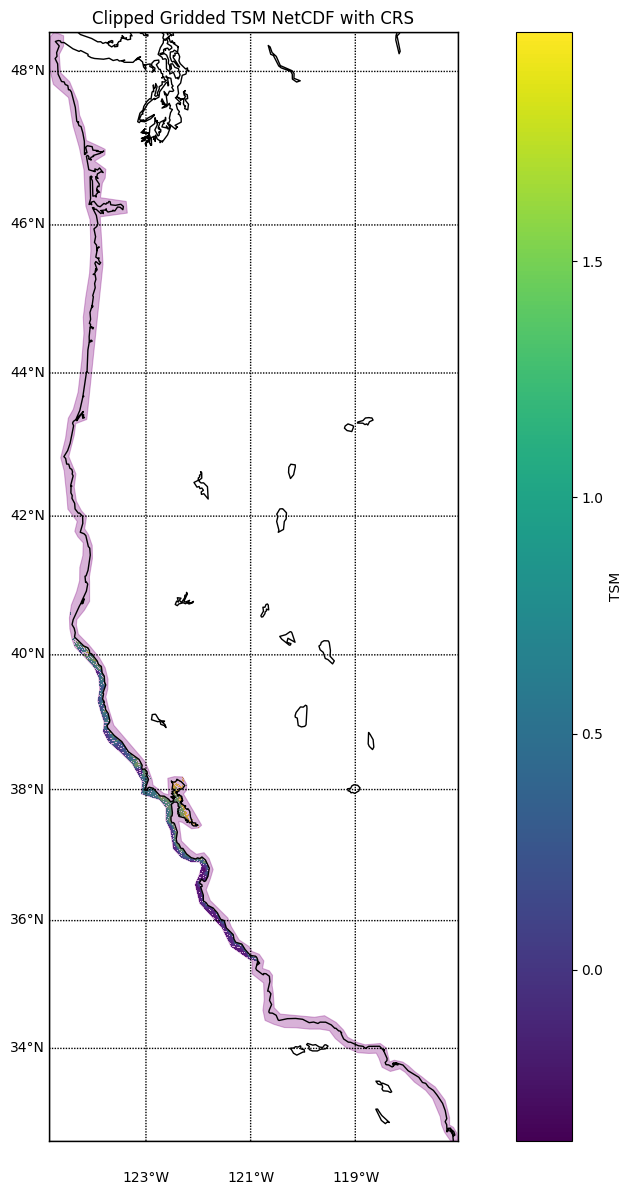

In [ ]:
# Plot clipped gridded TSM netcdf with CRS and ROI shapefile

# Load clipped NetCDF
clipped_ds = xr.open_dataset("/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_clip_crs.nc")
clipped_tsm = clipped_ds["TSM"].values
clipped_lats = clipped_ds["y"].values
clipped_lons = clipped_ds["x"].values

# Build 2D meshgrid
lon2d, lat2d = np.meshgrid(clipped_lons, clipped_lats)
masked_clipped = ma.masked_invalid(clipped_tsm)

# Plot with Basemap
fig, ax = plt.subplots(figsize=(12, 12))  # Wider figure

m = Basemap(
    projection='merc',
    llcrnrlat=np.min(clipped_lats),
    urcrnrlat=np.max(clipped_lats),
    llcrnrlon=np.min(clipped_lons),
    urcrnrlon=np.max(clipped_lons),
    resolution='i',
    ax=ax
)

m.drawcoastlines()
m.drawmapboundary()
m.drawparallels(np.arange(np.floor(np.min(lats)), np.ceil(np.max(lats)), 2), labels=[1,0,0,0])
m.drawmeridians(np.arange(np.floor(np.min(lons)), np.ceil(np.max(lons)), 1), labels=[0,0,0,1])

# Project coordinates
x, y = m(lon2d, lat2d)

# Plot TSM
cs = m.pcolormesh(x, y, masked_tsm, cmap='viridis', shading='auto')
plt.colorbar(cs, label="TSM NN (g.m-3)")

# Overlay ROI shapefile
shp_path = "/Users/lopezama/Documents/Blackwood/MERIS/ROI/west_us_poly_ll/west_us_poly_ll"  # without .shp extension
sf = shapefile.Reader(shp_path)
for shape_rec in sf.shapeRecords():
    shape = shape_rec.shape
    points = np.array(shape.points)
    parts = list(shape.parts) + [len(points)]
    for i in range(len(parts) - 1):
        seg = points[parts[i]:parts[i+1]]
        px, py = m(seg[:, 0], seg[:, 1])
        poly = Polygon(
            list(zip(px, py)),
            facecolor='purple',
            edgecolor='purple',
            linewidth=0.8,
            alpha=0.3  # 80% transparent 0.2, 50% transparent 0.5
        )
        ax.add_patch(poly)


plt.title("Clipped Gridded TSM NetCDF with CRS")
plt.tight_layout()
plt.show()

In [ ]:
# rasterio method 1 NetCDF to GeoTIFF - bad QGIS plot, good python plot

# Load dataset
ds = xr.open_dataset("/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_clip_crs.nc")
ds = ds.rename({'x': 'lon', 'y': 'lat'})  # rename if necessary

# Extract values
tsm = ds["TSM"].values
lats = ds["lat"].values
lons = ds["lon"].values

# Flip lat if needed
if lats[0] > lats[-1]:
    lats = lats[::-1]
    tsm = tsm[::-1, :]  # flip array to match ascending lat

# Compute resolution in degrees
res_lat = (lats[-1] - lats[0]) / (len(lats) - 1)
res_lon = (lons[-1] - lons[0]) / (len(lons) - 1)

# Top-left corner (lon, lat) = (min_lon, max_lat)
transform = from_origin(
    west=lons[0] - res_lon / 2,     # left edge
    north=lats[-1] + res_lat / 2,   # top edge
    xsize=res_lon,
    ysize=abs(res_lat)
)

# Save to GeoTIFF
out_meta = {
    "driver": "GTiff",
    "height": tsm.shape[0],
    "width": tsm.shape[1],
    "count": 1,
    "dtype": str(tsm.dtype),
    "crs": CRS.from_epsg(4326),
    "transform": transform,
    "nodata": np.nan
}

with rasterio.open("/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_clip1.tif", "w", **out_meta) as dst:
    dst.write(tsm, 1)



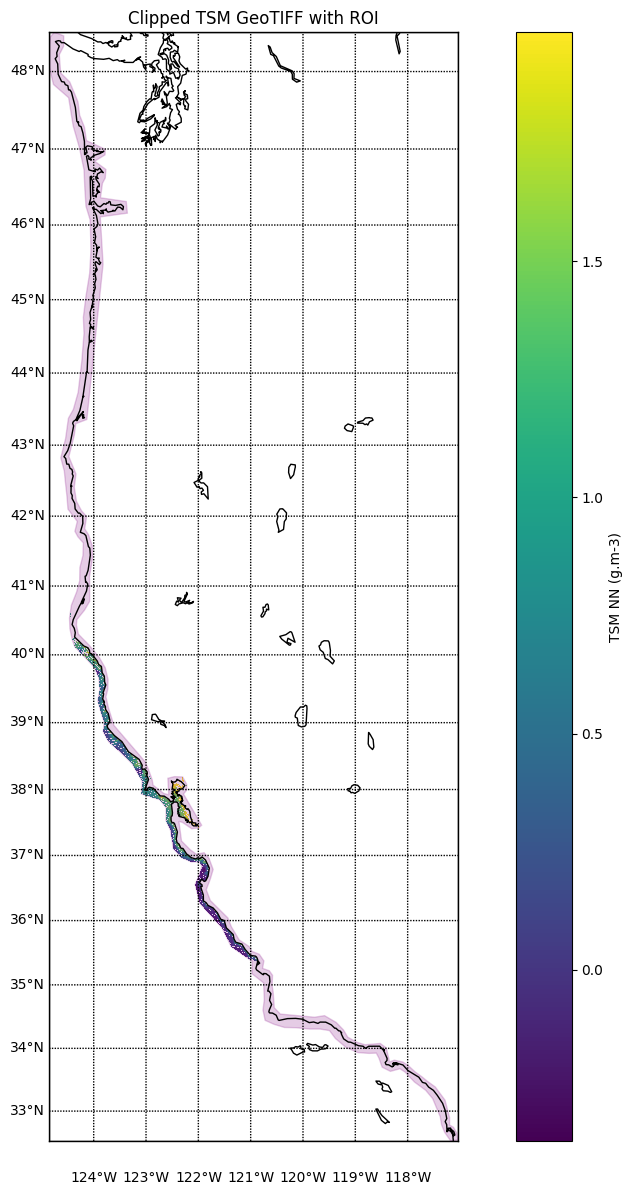

In [136]:
# Plot clipped gridded TSM geotiff - bad QGIS plot, good python plot

# Load ROI for overlay
roi = gpd.read_file("/Users/lopezama/Documents/Blackwood/MERIS/ROI/west_us_poly_ll/west_us_poly_ll.shp").to_crs("EPSG:4326")

# Reload GeoTIFF
raster = rasterio.open("/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_clip1.tif")
tsm_data = raster.read(1)
bounds = raster.bounds

# Grid for plotting
lons = np.linspace(bounds.left, bounds.right, tsm_data.shape[1])
lats = np.linspace(bounds.bottom, bounds.top, tsm_data.shape[0])
lon2d, lat2d = np.meshgrid(lons, lats)

# Plot with Basemap
fig, ax = plt.subplots(figsize=(12, 12))
m = Basemap(
    projection='merc',
    llcrnrlat=bounds.bottom,
    urcrnrlat=bounds.top,
    llcrnrlon=bounds.left,
    urcrnrlon=bounds.right,
    resolution='i',
    ax=ax
)

m.drawcoastlines()
m.drawmapboundary()

# Gridlines
m.drawparallels(np.arange(np.floor(bounds.bottom), np.ceil(bounds.top), 1), labels=[1,0,0,0])
m.drawmeridians(np.arange(np.floor(bounds.left), np.ceil(bounds.right), 1), labels=[0,0,0,1])

# Project coords
x, y = m(lon2d, lat2d)
masked = np.ma.masked_invalid(tsm_data)
cs = m.pcolormesh(x, y, masked, cmap="viridis", shading='auto')
plt.colorbar(cs, label="TSM NN (g.m-3)")

# ROI overlay
for shape in roi.geometry:
    x_roi, y_roi = m(*shape.exterior.xy)
    ax.fill(x_roi, y_roi, facecolor='purple', edgecolor='purple', alpha=0.2, linewidth=1)

plt.title("Clipped TSM GeoTIFF with ROI")
plt.tight_layout()
plt.show()

In [139]:
# rasterio method 2 NetCDF to GeoTIFF - good QGIS plot, bad python plot

ds = xr.open_dataset("/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_clip_crs.nc")

data_array = ds['TSM']

data_array = data_array.rio.set_spatial_dims('x', 'y')

data_array = data_array.rio.write_crs("epsg:4326")

data_array.rio.to_raster("/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_clip2.tif")

# Check info about new geotiff
with rasterio.open("/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_clip2.tif") as src:
    print("CRS:", src.crs) # CRS: None means missing spatial reference
    print("Bounds:", src.bounds) # Bounds: [nan, nan, nan, nan] means corrupt transformation
    print("Transform:", src.transform) # Transform: Affine(nan, nan, nan, nan, nan, nan means broken metadata
    print("Data shape:", src.shape)


CRS: EPSG:4326
Bounds: BoundingBox(left=-124.85244999999168, bottom=48.49905000000557, right=-117.03864999997904, top=32.52045000000076)
Transform: | 0.00, 0.00,-124.85|
| 0.00, 0.00, 32.52|
| 0.00, 0.00, 1.00|
Data shape: (5918, 2894)


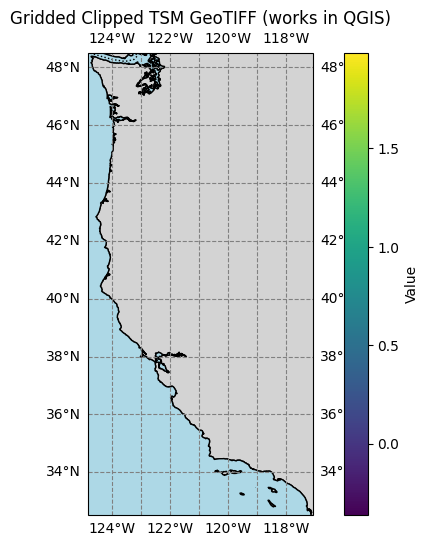

In [140]:
# Plot geotiff with basemap - good QGIS plot, bad python plot

def view_geotiff_with_basemap(file_path):
    """
    Opens and displays a GeoTIFF file with a basemap, handling NaN/Inf values properly.

    :param file_path: Path to the GeoTIFF file
    """
    with rasterio.open(file_path) as src:
        # Read data
        data = src.read(1).astype(np.float32)  

        # Handle NoData values
        if src.nodata is not None:
            data[data == src.nodata] = np.nan  

        # Check if all values are NaN
        if np.all(np.isnan(data)):
            raise ValueError(f"Error: The dataset {file_path} contains only NaN values and cannot be plotted.")

        # Compute extent
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

        # Mask invalid values
        data = np.ma.masked_invalid(data)

        # Create plot with Cartopy projection
        fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

        # Add basemap features
        ax.set_extent(extent, crs=ccrs.PlateCarree())  # Ensure correct extent
        ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')  # Land feature
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue')  # Ocean feature
        ax.add_feature(cfeature.BORDERS, linestyle=":")  # Country borders
        ax.add_feature(cfeature.COASTLINE, edgecolor="black")  # Coastline
        ax.gridlines(draw_labels=True, linestyle="--", color="gray")

        # Plot the raster data
        img = ax.imshow(data, cmap="viridis", extent=extent, origin="upper", transform=ccrs.PlateCarree())

        # Add colorbar
        cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=0.03, pad=0.04)
        cbar.set_label("Value")

        # Set title
        #plt.title(f"GeoTIFF Visualization with Basemap: {file_path}")
        plt.title(f"Gridded Clipped TSM GeoTIFF (works in QGIS)")

        # Show the plot
        plt.show()

# Example Usage
tsm_tif_fix = "/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_clip2.tif"  
view_geotiff_with_basemap(tsm_tif_fix)

In [141]:
# Look at order or lat and lon in clipped gridded TSM netcdf

# Load clipped dataset
ds = xr.open_dataset("/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_clip_crs.nc")
tsm = ds['TSM']

# Extract coordinates
lat = ds['y'].values
lon = ds['x'].values

# Assuming lat is your latitude array
print("First latitude value:", lat[0])
print("Last latitude value:", lat[-1])
print("First latitude value:", lon[0])
print("Last latitude value:", lon[-1])

if lat[0] > lat[-1]:
    print("✅ Latitude is ordered from north to south (descending).")
else:
    print("⚠️ Latitude is ordered from south to north (ascending). You may need to flip your data.")

First latitude value: 32.52180000000076
Last latitude value: 48.497700000005565
First latitude value: -124.85109999999167
Last latitude value: -117.03999999997905
⚠️ Latitude is ordered from south to north (ascending). You may need to flip your data.


In [143]:
# GDAL netcdf to raster - fails (no subdatasets)

input_nc = "/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_clip_crs.nc"
nc_ds = gdal.Open(input_nc)

print("Subdatasets found:")
for sub in nc_ds.GetSubDatasets():
    print(sub[0])

# Input and output paths
input_nc = "/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_clip_crs.nc"
output_tif = "/Users/lopezama/Documents/Blackwood/MERIS/scripts/envisat/test_data/20120401T184126/TSM_clip_gdal.tif"

# Open NetCDF file and specify the subdataset (e.g., 'TSM')
ds = gdal.Open(f"NETCDF:{input_nc}:TSM")

# Export using GDAL Translate
gdal.Translate(output_tif, ds)



Subdatasets found:


TypeError: Received a NULL pointer.